In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
import numpy as np 
from astropy.io import ascii
from scipy.integrate import simps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os 
import cmasher as cmr
from scipy.optimize import curve_fit
data_dir = os.getenv("DATADIR")
plt.style.use(data_dir+'bl.mplstyle')

def Absolute_to_Apparent(AbsoluteMag,distance):
    return AbsoluteMag + 5 * (np.log10(distance/10))

#Function to figure out bluewards vs. not: 
def calc_blueZAMS(data_x,data_y,zams_blue,zams_red):
    curve_x = np.array(zams_blue) - np.array(zams_red)
    curve_y = np.array(zams_blue)
    zams_color_ref = np.interp(data_y,np.flip(curve_y,0),np.flip(curve_x,0))
    ZAMS_distance = data_x - zams_color_ref
    return ZAMS_distance
# Fitting a line
def func(x, a, b):
    return a * x + b
# Constants and definitions:
distance = {'smc': 60.6e3, 'lmc': 50e3} # distance in parsecs

# Fiducial Values
Av0 = {'smc': 0.22, 'lmc': 0.38} # Av0 for the SMC and LMC
smc_extinction_coeff = {'uvw2':3.522767303652845, 'uvm2':3.062652780996107, 'uvw1':2.7436011426496876, 'u':1.746851127566682, 'b':1.4073996800012445, 'v':1.0353852912271932, 'i':0.5911705440475679}
lmc_extinction_coeff = {'uvw2':2.644541680555541, 'uvm2':2.7233599880955124, 'uvw1':2.3536449902431045, 'u':1.5634790597438197, 'b':1.3170082045312625, 'v':1.0333402844940784, 'i':0.7366865234305091}
extinction_coeff = {'smc': smc_extinction_coeff, 'lmc': lmc_extinction_coeff}

###############
# M o d e l s #
###############
# This is ZAMS_Z0.00X_ABmag.txt converted to apparent magnitudes
zams = {'smc': pd.read_csv(data_dir+"1_Models/ZAMS/smc_zams_apparent.csv"),'lmc': pd.read_csv(data_dir+"1_Models/ZAMS/lmc_zams_apparent.csv")}

comp_file = data_dir + '1_Models/Stripped_Stars/photometry_CMFGEN_composites.txt'
# Renaming M_MS to m to be consistent with the zams file
cols = ['Minit_strip','m','frac_MS','u','b','v','r','i','uvm2','uvw2','uvw1']
comp_photom = pd.read_csv(comp_file,comment='#',sep='\t',names=cols)
# Remove the r band, as it is not used in the analysis
comp_photom = comp_photom.drop('r', axis=1)
cols = comp_photom.columns
# Select just the MS at less than 30% of the MS lifetime
comp_photom =comp_photom[(comp_photom['frac_MS'] < 0.3) & (comp_photom['Minit_strip'] == 0) ].reset_index(drop=True)
comp = {'smc':comp_photom.copy(), 'lmc':comp_photom.copy()}

for galaxy in ['smc','lmc']:
    # Convert to apparent magnitudes
    for col in cols[3:]:
        comp[galaxy][col] = Absolute_to_Apparent(comp[galaxy][col],distance[galaxy])
    
    # Select zams to just be the same mass range as the models
    zams[galaxy] = zams[galaxy][zams[galaxy].m < 19].reset_index(drop=True)

#######################
# E x t i n c t i o n #
#######################
def change_red_photometry(dfs):
    uv_col = 'uvm2'
    opt_col = 'v'
    dict = {}
    for galaxy in ['smc','lmc']:
        step = 0.01
        Av_list = np.arange(0.00,Av0[galaxy]+step,step)
        df_list = [] 
        for av in Av_list:
            # Copy the synthetic photometry dataframe
            new_df = dfs[galaxy].copy()
            # Make flag col
            new_df['flag'] = 'normal'
            # Deredden the synthetic photometry
            dered_Av = Av0[galaxy] - av
            for col in cols[3:]:
                new_df[col] = new_df[col] - extinction_coeff[galaxy][col] * dered_Av
            # Make a z_distance column             # X                         # Y                  UV                # Opt
            new_df['z_dis'] = calc_blueZAMS(new_df[uv_col]-new_df[opt_col],new_df[uv_col],zams[galaxy][uv_col],zams[galaxy][opt_col])
            # If the uv color falls out of our range, set the z_distance to 0
            new_df.loc[(new_df[uv_col] > 19) | (new_df[uv_col] < 14 ), 'flag'] = 'out_of_range'
            # Add the new dataframe to the dictionary
            df_list.append(pd.DataFrame({'av':np.repeat(av,len(new_df)),'m_ms':new_df['m'].values,'z_dis':new_df['z_dis'].values,'flag':new_df['flag'].values}))
        # Concatenate all the dataframes in the list
        dict[galaxy] = pd.concat(df_list, ignore_index=True)
    return dict

dephot = change_red_photometry(comp)
dezams = change_red_photometry(zams)


/var/folders/v7/3cz8p5d553b7s1dcymxc7m1hdpkh95/T/ipykernel_31785/3527854530.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


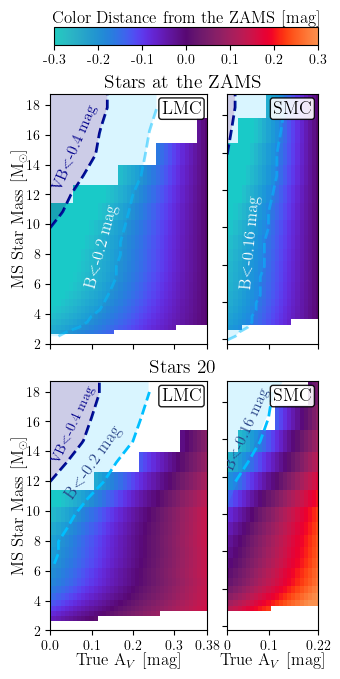

In [ ]:
###########
# P L O T #
###########

size_high = 0.38/(0.38+0.22)
size_low = 0.22/(0.38+0.22)

f, axes = plt.subplots(2,2,figsize=(3.35,3.35*2),gridspec_kw={'width_ratios': [size_high,size_low],'wspace':0.16,'hspace':0.15})#,dpi=180,)

cm = cmr.guppy_r
grid_alpha = 1
df = dephot['smc']

#  Make Grid 
def make_grid(df):
    X = df.av.unique()
    Y = df.m_ms.unique()
    X,Y = np.meshgrid(X,Y)
    X_flat,Y_flat = X.flatten(),Y.flatten()
    Z,F = [],[]
    for a,m in zip(X_flat,Y_flat):
        Z.append(df[(df.av == a) & (df.m_ms == m)]['z_dis'].values)
        F.append(df[(df.av == a) & (df.m_ms == m)]['flag'].values)
    F = np.array(F).reshape(X.shape)
    Z = np.array(Z).reshape(X.shape)
    return X,Y,Z,F
def mask(Z,F):
    return np.ma.masked_array(Z,F == 'out_of_range')
def very_blue_line(X,Y,Z,val):
    # Make a 1,0 mask for where the VB points are
    Z_VB = np.zeros_like(Z)
    Z_VB[Z < val] = 1
    # Apply to our parameter space
    X= X*Z_VB
    Y= Y*Z_VB
    X,Y = X.flatten(),Y.flatten()
    # Remove the zeroes we added
    X=X[Y != 0]
    Y=Y[Y != 0]
    # Get the outer edges of the VB points
    y_unique = np.sort(np.unique(Y))
    xs = []
    for y in y_unique:
        x = X[Y == y]
        x = np.max(x)
        xs.append(x)
    xs = np.array(xs)
    # Fit a line to the points
    popt, pcov = curve_fit(func, xs,y_unique)
    x2 = np.linspace(0,0.38,100)
    y = func(x2, *popt) 
    # Vertical line along 0
    x1 = np.repeat(0,len(y))
    # Interpolate between xs, y_unique
    x3 = np.linspace(0,0.38,len(y))
    y3 = np.interp(x3,xs,y_unique,right=100)
    return x1, x2, y,x3, y3, xs, y_unique


# Colorbar range
vmin,vmax = -0.3,0.3
# Shading Colors / Alphas
shade_color_1 = 'darkblue'
shade_color_2 = 'deepskyblue'
shade_alpha_1 = 0.2
shade_alpha_2 = 0.15
# Median values for the LMC and SMC
lmc_b = -0.2
smc_b = -0.16

# First
X,Y,Z,F = make_grid(dezams['lmc'])
pcol = axes[0,0].pcolormesh(X,Y,mask(Z,F),cmap=cm,linewidth=1,alpha=grid_alpha,rasterized=True,zorder=-1,vmin=vmin,vmax=vmax)
vb_x1,vb_x2,vb_y,vb_x3,vb_y3,vb_xs, vb_ys= very_blue_line(X,Y,Z,-0.4)
axes[0,0].fill_betweenx(vb_y3,vb_x1,vb_x3,facecolor=shade_color_1,alpha=shade_alpha_1,zorder=1)
axes[0,0].plot(vb_x3,vb_y3,linestyle='--',color=shade_color_1,alpha=1,zorder=1)
x1,x2,y,x3,y3,xs,ys = very_blue_line(X,Y,Z,lmc_b)
# Interpolate between xs, y_unique
axes[0,0].plot(xs,ys,color=shade_color_2,alpha=0.5,zorder=1,linestyle='--')
axes[0,0].fill_between(x3,vb_y3,y3,facecolor=shade_color_2,alpha=shade_alpha_2,zorder=1)


## SECOND
X,Y,Z,F = make_grid(dezams['smc'])
pcol = axes[0,1].pcolormesh(X,Y,mask(Z,F),cmap=cm,linewidth=1,alpha=grid_alpha,rasterized=True,zorder=-1,vmin=vmin,vmax=vmax)
vb_x1,vb_x2,vb_y,vb_x3,vb_y3,vb_xs, vb_ys= very_blue_line(X,Y,Z,-0.4)
axes[0,1].fill_betweenx(vb_y3,vb_x1,vb_x3,facecolor=shade_color_1,alpha=shade_alpha_1,zorder=1)
axes[0,1].plot(vb_x3,vb_y3,linestyle='--',color=shade_color_1,alpha=1,zorder=1)
x1,x2,y,x3,y3,xs,ys = very_blue_line(X,Y,Z,smc_b)
axes[0,1].plot(xs,ys,color=shade_color_2,alpha=0.5,zorder=1,linestyle='--')
axes[0,1].fill_between(x3,vb_y3,y3,facecolor=shade_color_2,alpha=shade_alpha_2,zorder=1)


## THIRD 
X,Y,Z,F = make_grid(dephot['lmc'])
pcol = axes[1,0].pcolormesh(X,Y,mask(Z,F),cmap=cm,linewidth=1,alpha=grid_alpha,rasterized=True,zorder=-1,vmin=vmin,vmax=vmax)
vb_x1,vb_x2,vb_y,vb_x3,vb_y3,vb_xs, vb_ys= very_blue_line(X,Y,Z,-0.4)
axes[1,0].fill_betweenx(vb_y3,vb_x1,vb_x3,facecolor=shade_color_1,alpha=shade_alpha_1,zorder=1)
axes[1,0].plot(vb_x3,vb_y3,linestyle='--',color=shade_color_1,alpha=1,zorder=1)
x1,x2,y,x3,y3,xs,ys  = very_blue_line(X,Y,Z,lmc_b)
axes[1,0].plot(xs,ys,linestyle='--',color=shade_color_2,alpha=1,zorder=1)
axes[1,0].fill_between(x3,vb_y3,y3,facecolor=shade_color_2,alpha=shade_alpha_2,zorder=1)

## FOURTH
X,Y,Z,F = make_grid(dephot['smc'])
pcol = axes[1,1].pcolormesh(X,Y,mask(Z,F),cmap=cm,linewidth=1,alpha=grid_alpha,rasterized=True,zorder=-1,vmin=vmin,vmax=vmax)
x1,x2,y,x3,y3,xs,ys = very_blue_line(X,Y,Z,smc_b)
axes[1,1].plot(xs,ys,linestyle='--',color=shade_color_2,alpha=1,zorder=1)
axes[1,1].fill_betweenx(y,x1,x3,facecolor=shade_color_2,alpha=shade_alpha_2+0.,zorder=1)


####################
# Labels and Ticks #
####################
label_size = 12
tick_size = 10
gal_size=13
# Axis Limits
[ax.set_xlim(0,0.38) for ax in axes[:,0]]
[ax.set_xlim(0.0,0.22) for ax in axes[:,1]]
[ax.set_ylim(2.2,18.9) for ax in axes.flatten()]
# Axis Labels
[ax.set_xlabel(r'True A$_V$ [mag]',fontsize=label_size) for ax in axes[1,:]]
[ax.set_ylabel(r'MS Star Mass [M$_\odot$]',fontsize=label_size) for ax in axes[:,0]]
# Ticks 
[ax.set_yticklabels([]) for ax in axes[:,1]]
[ax.set_xticklabels([]) for ax in axes[0,:]]
lmc_xticks = np.linspace(0,0.38,4)
lmc_xticks = [0.0,0.1,0.2,0.3,0.38]
lmc_xticklabels = [f'{i:.2f}' for i in lmc_xticks]
lmc_xticklabels=[str(i) for i in lmc_xticks]
[ax.set_xticks(lmc_xticks) for ax in axes[:,0]]
axes[1,0].set_xticklabels(lmc_xticklabels,fontsize=tick_size)
smc_xticks = np.linspace(0.05,0.22,3)
smc_xticks = [0,0.1,0.22]
smc_xticklabels = [f'{i:.2f}' for i in smc_xticks]
smc_xticklabels=[str(i) for i in smc_xticks]
[ax.set_xticks(smc_xticks) for ax in axes[:,1]]
axes[1,1].set_xticklabels(smc_xticklabels,fontsize=tick_size)
yticks = np.arange(2.2,20,2)
yticklabels = [f'{i:.0f}' for i in yticks]
[ax.set_yticks(yticks) for ax in axes[:,0]]
[ax.set_yticklabels(yticklabels,fontsize=tick_size) for ax in axes[:,0]]
# Galaxy Labels 
gal_height = 0.852
gal_height = 0.842
gal_color='k'
props = dict(boxstyle='round', facecolor='white', alpha=0.9,pad=0.15)
plt.text(.828+0.045,gal_height, 'SMC', transform=f.transFigure, horizontalalignment='center',fontsize=gal_size,color=gal_color,bbox=props)
plt.text(.507+0.035,gal_height, 'LMC', transform=f.transFigure, horizontalalignment='center',fontsize=gal_size,color=gal_color,bbox=props)
gal_height = 0.44
gal_height = 0.413
plt.text(.828+0.045, gal_height, 'SMC', transform=f.transFigure, horizontalalignment='center',fontsize=gal_size,color=gal_color,bbox=props,zorder=100)
plt.text(.507+0.035,gal_height, 'LMC', transform=f.transFigure, horizontalalignment='center',fontsize=gal_size,color=gal_color,bbox=props)
# Suptitles 
plt.text(.55,0.88, 'Stars at the ZAMS', transform=f.transFigure, horizontalalignment='center',fontsize=14,weight='bold')
plt.text(.55,0.455, 'Stars 20% through the MS', transform=f.transFigure, horizontalalignment='center',fontsize=14,weight='bold')

##################
# AV Line Labels #
##################
av_text_color2 = 'white' #'cyan'
axes[0,0].text(0.001, 12.5, r'VB$<$-0.4 mag', fontsize=tick_size+1, color=shade_color_1,rotation=67)
axes[0,0].text(0.08, 6, rf'B$<${lmc_b} mag', fontsize=tick_size+2, color=av_text_color2 ,rotation=75)
axes[0,1].text(0.03, 6, rf'B$<${smc_b} mag', fontsize=tick_size+2, color=av_text_color2 ,rotation=85)
av_text_color2 = '#284387' #'navy'#'#4682B4'#'#4169E1'#'mediumblue'#'#007fff' #'blue'#'#87CEEB'#(1, 0.25, 0, 1) #'#shade_color_2#'cyan'#00BFFF'#
axes[1,0].text(0.00, 13.4, r'VB$<$-0.4 mag', fontsize=tick_size, color=shade_color_1,rotation=65,clip_on=True)
axes[1,0].text(0.03, 11, rf'B$<${lmc_b} mag', fontsize=tick_size+2, color=av_text_color2 ,rotation=55)

axes[1,1].text(-0.01, 13., rf'B$<${smc_b} mag', fontsize=tick_size+1, color=av_text_color2 ,rotation=66,weight='heavy',clip_on=True)

############
# Colorbar #
############

axins = inset_axes(axes[0,1], # here using axis of the lowest plot
               width="290%",  # width = X% of parent_bbox width
               height="7%",  
               bbox_to_anchor=(0, 0.27, 1., 1.),
               bbox_transform=axes[0,1].transAxes,
               borderpad=0,
               )
ticks = list(np.arange(vmin,vmax+0.1,0.1))
tick_labels = [f'{i:.1f}' for i in ticks]
cbar = f.colorbar(pcol, cax=axins,ticks=ticks,orientation='horizontal')
cbar.ax.set_xticklabels(tick_labels,fontsize=tick_size) 
cbar.set_label('Color Distance from the ZAMS [mag]',fontsize=label_size,labelpad=-41)
plt.tight_layout()
plt.subplots_adjust(top=0.87,right=0.95,left=0.15,bottom=0.07)

plt.savefig('MScontaminants_BL.pdf', dpi=1000)

